In [542]:
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import parse_data.flip_rotate_trajectories as rotate
from analysis.response_times import calculate_response_times, plot_response_times
import data_extraction.get_indices as get_indices
import plotting.plot_octagon as plot_octagon
import globals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import analysis.loser_inferred_choice as loser_inferred_choice
import seaborn as sns
import data_strings
import data_extraction.trial_list_filters as trial_list_filters


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [543]:
data_folder = data_strings.DATA_FOLDER
json_filenames_all_social = data_strings.JSON_FILENAMES_SOCIAL
json_filenames_all_solo = data_strings.JSON_FILENAMES_SOLO

In [544]:
solo = False

In [545]:
if solo:
    json_filenames = json_filenames_all_solo
    
else:
    json_filenames = json_filenames_all_social
    

In [546]:
# prepare the session dataframe and dataframes of each individual trial
if solo:
    df, trial_lists = prepare_data.prepare_data(data_folder, json_filenames, combine=False)
    print(len(trial_lists))
    trial_lists = [trial_lists[i] + trial_lists[i+1] for i in range(0, len(trial_lists), 2)]

else:
    df, trial_lists = prepare_data.prepare_data(data_folder, json_filenames, combine=False)

filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\second_experiments_2409\240927\2024-09-27_14-25-20_SaraEmilySocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\third_experiments_2410\241017\2024-10-17_14-28-40_ShamirAbigailSocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fifth_experiments_241112\2024-11-12_13-31-14_KhadijaWendySocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\sixth_experiments_241112\2024-11-12_15-23-24_Franc

In [547]:
# get_indices.get_trials_with_wall_sep(trial_list=trial_lists, wall_sep=1).size

In [548]:
## HEATMAPS ##

In [549]:
## sandbox for P(wall | first vis) heatmap
# first, write code to gather location counts data for one player
# Then, allow looping over all players so that location counts can be summed together, but still retain the data
# for individuals

# The cleanest way to do this will be to work with dataframes directly
# create a dictionary with nested dictionaries for session ids, which contain filtered lists of dataframes for each player
# be aware of the df trail number misaligning with the trial df index if I was looping instead 

# when I do global analysis, I just take this dictionary, and flatten it, concatenating all of the lists

#### general analysis structure

In [550]:
# create dictionary to store filtered lists of dataframes for each player
filtered_data = {}
for session_id, trial_list in enumerate(trial_lists):
    # create the nested dictionary for session_id
    filtered_data[session_id] = {}

    player_ids = [0] if solo else [0,1]
    for player_id in player_ids:
        # do some filtering to this trial list for this player_id
        filtered_trial_list = []

        # append the filtered trial list to the dictionary
        filtered_data[session_id, player_id] = filtered_trial_list

#### filtering functions used to get P(H|H first vis) and P(H|L first vis) trials

In [551]:
# variables for filtering function
trial_list = trial_lists[1]
inferred_choice = True
current_fov =110
wall_visible_index= 1
chosen_wall_index = 0
wall_sep = 4

In [552]:
def heatmap_trial_list_filterer_numerator(trial_list, player_id, inferred_choice, current_fov, wall_visible_index,
                                chosen_wall_index, debug=False):
    ''' Filter all trials where player has a retrievable choice, saw the wall_visible_index wall first, and chose
        the chosen_wall_index'''    
    

    print(f" trial list: {type(trial_list)}, length {len(trial_list)}")
    print(f"player_id: {type(player_id)}")
    # filter for retrievable choice, then where visible_wall_index becomes visible first, then where player chose High
    trial_list_filtered, original_indices = trial_list_filters.filter_trials_retrievable_choice(trial_list, player_id, inferred_choice, original_indices=None,
                                        debug=False)
    
    
    if wall_visible_index is not None:
        trial_list_filtered, original_indices = trial_list_filters.filter_trials_one_wall_becomes_visible_first(trial_list_filtered, player_id,
                                                        current_fov, wall_index=wall_visible_index,
                                                        original_indices=original_indices,
                                                        debug=False)

    trial_list_filtered, original_indices = trial_list_filters.filter_trials_player_chose_given_wall(trial_list_filtered, player_id,
                                                                inferred_choice,
                                                                given_wall_index=chosen_wall_index,
                                                                original_indices=original_indices,
                                                                debug=False)
    
    return trial_list_filtered, original_indices


In [553]:
def heatmap_trial_list_filterer_denominator(trial_list, player_id, inferred_choice, current_fov, wall_visible_index,
                                            debug=False):    
    ''' Filter all trials where player has a retrievable choice, and saw the wall_visible_index wall first'''  

    print(f" trial list: {type(trial_list)}, length {len(trial_list)}")
    print(f"player_id: {type(player_id)}")
    # filter for retrievable choice, then where visible_wall_index becomes visible first, then where player chose High
    trial_list_filtered, original_indices = trial_list_filters.filter_trials_retrievable_choice(trial_list, player_id, inferred_choice, original_indices=None,
                                        debug=False)
    
    
    trial_list_filtered, original_indices = trial_list_filters.filter_trials_one_wall_becomes_visible_first(trial_list_filtered, player_id,
                                                    current_fov, wall_index=wall_visible_index,
                                                    original_indices=original_indices,
                                                    debug=False)

    return trial_list_filtered, original_indices


#### condition filtering applied to general structure

In [554]:
# create dictionary to store filtered lists of dataframes for each player
filtered_trials_denominator = {}
for session_id, trial_list in enumerate(trial_lists):
    # create the nested dictionary for session_id
    filtered_trials_denominator[session_id] = {}

    # filter trial list for specified trial type (e.g., HIGH_LOW)
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
    trial_list = [trial_list[i] for i in trial_indices]

    if wall_sep is not None:
        # if notebook global variable for wall separation is True, also filter by this
        trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep)
        trial_list = [trial_list[i] for i in trial_indices]

    inferred_choice = False if solo else inferred_choice
    player_ids = [0] if solo else [0,1]
    for player_id in player_ids:
        # do some filtering to this trial list for this player_id
        trial_list_filtered, _ = heatmap_trial_list_filterer_denominator(trial_list, player_id, 
                                    inferred_choice, current_fov, wall_visible_index, debug=False)

        # append the filtered trial list to the dictionary
        print(session_id, player_id)
        filtered_trials_denominator[session_id][player_id] = trial_list_filtered

 trial list: <class 'list'>, length 27
player_id: <class 'int'>
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
And the number of valid trials at this step is 11
0 0
 trial list: <class 'list'>, length 27
player_id: <class 'int'>
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1.]
And the number of valid trials at this step is 10
0 1
 trial list: <class 'list'>, length 17
player_id: <class 'int'>


d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
And the number of valid trials at this step is 1
1 0
 trial list: <class 'list'>, length 17
player_id: <class 'int'>
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.]
And the number of valid trials at this step is 8
1 1
 trial list: <class 'list'>, length 27
player_id: <class 'int'>
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
And the number of valid trials at this step is 6
2 0
 trial list: <class 'list'>, length 27
player_id: <class 'int'>
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 0.]
And the number of valid trials at this step is 11
2 1
 trial list: <cl

#### condition + choice filtering applied to general structure

In [555]:
# create dictionary to store filtered lists of dataframes for each player
filtered_trials_numerator = {}
for session_id, trial_list in enumerate(trial_lists):
    # create the nested dictionary for session_id
    filtered_trials_numerator[session_id] = {}

    # filter trial list for specified trial type (e.g., HIGH_LOW)
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
    trial_list = [trial_list[i] for i in trial_indices]

    if wall_sep is not None:
        # if notebook global variable for wall separation is True, also filter by this
        trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep)
        trial_list = [trial_list[i] for i in trial_indices]

    inferred_choice = False if solo else inferred_choice
    player_ids = [0] if solo else [0,1]
    for player_id in player_ids:
        # do some filtering to this trial list for this player_id
        trial_list_filtered, _ = heatmap_trial_list_filterer_numerator(trial_list, player_id, 
                                    inferred_choice, current_fov, wall_visible_index,
                                    chosen_wall_index, debug=False)

        # append the filtered trial list to the dictionary
        print(session_id, player_id)
        filtered_trials_numerator[session_id][player_id] = trial_list_filtered

 trial list: <class 'list'>, length 27
player_id: <class 'int'>
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
And the number of valid trials at this step is 11
0 0
 trial list: <class 'list'>, length 27
player_id: <class 'int'>
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1.]
And the number of valid trials at this step is 10
0 1
 trial list: <class 'list'>, length 17
player_id: <class 'int'>
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
And the number of valid trials at this step is 1
1 0
 trial list: <class 'list'>, length 17
player_id: <class 'int'>
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.

#### With the raw (filtered) trials, create an overall analysis dictionary

In [556]:
for i in range(10):
    print(len(analysis_results[i][0]['filtered_trials']['denominator']))

12
2
10
13
4
18
11
9
11
17


In [557]:
analysis_results = {
    session_id: {
        player_id: {

            # filtered, then flipped-and-rotated trial dataframes
            'filtered_trials': {
                'numerator': filtered_trials_numerator[session_id][player_id],
                'denominator': filtered_trials_denominator[session_id][player_id],
                'numerator_flipped_rotated': None,
                'denominator_flipped_rotated': None
            },

            # trial start positions
            'positions': {
                'positions_numerator': None,
                'positions_denominator': None,
            },

            # grids of count data per trial
            'grids': {
                'grid_numerator': None,
                'grid_denominator': None,
                'grid_ratio': None # ratio of numerator to denominator grids
            }
        }
        for player_id in filtered_trials_numerator[session_id]
    }
    for session_id in filtered_trials_numerator
}

#### flip and rotate filtered trials so that trial positions are comparable

In [558]:
# Add the flipped-rotated version of the trials to the dictionary
for session_id, players in analysis_results.items():
    for player_id, data in players.items():
        player_data = analysis_results[session_id][player_id]
        player_trials_numerator = data['filtered_trials']['numerator']
        player_data['filtered_trials']['numerator_flipped_rotated'] = [rotate.flip_rotate_trajectories(trial=trial) 
                                                            for trial in player_trials_numerator]
for session_id, players in analysis_results.items():
    for player_id, data in players.items():
        player_data = analysis_results[session_id][player_id]
        player_trials_denominator = data['filtered_trials']['denominator']
        player_data['filtered_trials']['denominator_flipped_rotated'] = [rotate.flip_rotate_trajectories(trial=trial) 
                                                            for trial in player_trials_denominator]

#### Store location at trial start for each trial in denominator and numerator trials

In [559]:
test_sum = 0
for session_id, players in analysis_results.items():
    for player_id, data in players.items():
        print(len(data['filtered_trials']['denominator']))
        test_sum += len(data['filtered_trials']['denominator'])

print(test_sum)


11
10
1
8
6
11
17
16
4
6
7
7
12
9
4
8
9
6
14
7
10
15
9
8
7
5
3
4
17
22
15
22
15
22
11
13
4
6
381


In [560]:
# for each session id and then for each player id in the dictionary
# access the relevant player slice onset location and create a list entry storing these locations

for session_id, players in analysis_results.items():
    for player_id, data in players.items():
        player_data = analysis_results[session_id][player_id]
        player_trials_numerator = data['filtered_trials']['numerator_flipped_rotated']
        player_data['positions']['positions_numerator'] = np.array(
                                                        [get_indices.get_player_slice_onset_loc(trial, player_id) 
                                                         for trial in player_trials_numerator],
                                                        dtype=np.float32
                                                        )

        
for session_id, players in analysis_results.items():
    for player_id, data in players.items():
        player_data = analysis_results[session_id][player_id]
        player_trials_denominator = data['filtered_trials']['denominator_flipped_rotated']
        player_data['positions']['positions_denominator'] = np.array(
                                                        [get_indices.get_player_slice_onset_loc(trial, player_id)
                                                          for trial in player_trials_denominator],
                                                        dtype=np.float32
                                                        )

In [561]:
analysis_results[5][0]['positions']['positions_numerator']

array([[-0.28,  4.02]], dtype=float32)

#### Sort slice onset locations into spatially-binned count arrays (function and logic)

In [562]:
x_min = -20
x_max = 20
y_min = -20
y_max = 20

In [563]:
def heatmap_counts_from_location_data(location_array, n_rows=10, n_cols=10, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max):
    ''' Produce a matrix of counts across spatial location from n*2 location data '''

    # define a grid of counts
    grid_width = (x_max - x_min)/n_cols
    grid_height = (y_max - y_min)/n_rows
    grid = np.zeros([n_rows, n_cols])

    try:
        # Create a matrix of heatmap counts based on which bin starting location fits into
        for i in range(len(location_array[:,0])):
            x_val = location_array[i,0]
            y_val = location_array[i,1]
            x_bin = int((x_val - x_min)/grid_width)
            y_bin = int((y_val - y_min)/grid_height)

            if 0 <= y_bin < n_rows and 0 <= x_bin < n_cols:
                grid[y_bin, x_bin] += 1
    except IndexError:
        grid = grid # no values in location array

    return grid

In [564]:
n_rows = 8
n_cols = 8

In [565]:
# create new dictionaries to store a grid of slice-onset location count arrays 

for session_id, players in analysis_results.items():
    for player_id, data in players.items():
        player_data = analysis_results[session_id][player_id]
        location_array = player_data['positions']['positions_numerator']
        player_data['grids']['grid_numerator'] = heatmap_counts_from_location_data(location_array,n_rows=n_rows, n_cols=n_cols,
                                                                        x_min=x_min, x_max=x_max, 
                                                                        y_min=y_min, y_max=y_max)
for session_id, players in analysis_results.items():
    for player_id, data in players.items():
        player_data = analysis_results[session_id][player_id]
        location_array = player_data['positions']['positions_denominator']
        player_data['grids']['grid_denominator'] = heatmap_counts_from_location_data(location_array,n_rows=n_rows, n_cols=n_cols,
                                                                        x_min=x_min, x_max=x_max, 
                                                                        y_min=y_min, y_max=y_max)


#### Calculate numerator/denominator ratio for each bin

In [566]:
for session_id, players in analysis_results.items():
    for player_id, data in players.items():
        player_data = analysis_results[session_id][player_id]
        player_data['grids']['grid_ratio'] = player_data['grids']['grid_numerator']/player_data['grids']['grid_denominator']

C:\Users\Tom\AppData\Local\Temp\ipykernel_1588\2111596262.py:4: RuntimeWarning: invalid value encountered in divide
  player_data['grids']['grid_ratio'] = player_data['grids']['grid_numerator']/player_data['grids']['grid_denominator']


#### find the average grid across all data

In [567]:
numerator_array_list = [analysis_results[session_id][player_id]['grids']['grid_numerator']
 for session_id in analysis_results
 for player_id in analysis_results[session_id]
 ]
denominator_array_list = [analysis_results[session_id][player_id]['grids']['grid_denominator']
 for session_id in analysis_results
 for player_id in analysis_results[session_id]
 ]


In [568]:
flipped_rotated_denominator_array_list = [analysis_results[session_id][player_id]['filtered_trials']['denominator_flipped_rotated']
 for session_id in analysis_results
 for player_id in analysis_results[session_id]
 ]

flipped_rotated_denominator_array_list = [trial
                                        for player in flipped_rotated_denominator_array_list
                                        for trial in player
]

In [569]:
raw_denominator_array_list = [analysis_results[session_id][player_id]['filtered_trials']['denominator']
 for session_id in analysis_results
 for player_id in analysis_results[session_id]
 ]

raw_denominator_array_list = [trial
                            for player in raw_denominator_array_list
                            for trial in player
]

In [570]:
# type(raw_denominator_array_list[0])

In [571]:
len(raw_denominator_array_list)

381

In [572]:
flipped_rotated_denominator_array_list_short = flipped_rotated_denominator_array_list[700:800]

In [573]:
import pickle
import os
my_variable = flipped_rotated_denominator_array_list_short
shared_path = os.path.join("..", "shared_data", "my_variable.pkl")
with open("my_variable.pkl", "wb") as f:
    pickle.dump(my_variable, f)

In [574]:
n = len(numerator_array_list)
summed_numerator = np.nansum(numerator_array_list, axis=0)
summed_denominator =  np.nansum(denominator_array_list, axis=0)
ratio_array_aggregate = summed_numerator/summed_denominator


C:\Users\Tom\AppData\Local\Temp\ipykernel_1588\3986122267.py:4: RuntimeWarning: invalid value encountered in divide
  ratio_array_aggregate = summed_numerator/summed_denominator


In [575]:
summed_denominator

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  3.,  2.,  1.,  0.,  0.],
       [ 0.,  3.,  8.,  7., 10.,  1.,  1.,  0.],
       [ 0.,  1.,  9., 43., 48.,  9.,  4.,  0.],
       [ 0.,  6., 14., 55., 62., 15.,  1.,  1.],
       [ 0.,  3.,  5., 14., 20.,  5.,  4.,  2.],
       [ 0.,  4.,  4.,  3.,  2.,  3.,  1.,  0.],
       [ 0.,  0.,  0.,  2.,  2.,  1.,  0.,  0.]])

In [576]:
np.set_printoptions(precision=2, suppress=True)  # Format numbers
ratio_array_aggregate

array([[ nan,  nan,  nan, 0.  ,  nan,  nan,  nan,  nan],
       [ nan, 0.  ,  nan, 0.67, 0.  , 0.  ,  nan,  nan],
       [ nan, 0.33, 0.  , 0.29, 0.2 , 0.  , 0.  ,  nan],
       [ nan, 0.  , 0.44, 0.42, 0.33, 0.22, 0.  ,  nan],
       [ nan, 0.17, 0.14, 0.42, 0.26, 0.07, 0.  , 0.  ],
       [ nan, 0.  , 0.4 , 0.21, 0.1 , 0.  , 0.  , 0.  ],
       [ nan, 0.75, 0.5 , 1.  , 0.  , 0.  , 0.  ,  nan],
       [ nan,  nan,  nan, 0.5 , 0.  , 1.  ,  nan,  nan]])

#### Use a cut-off for bins with fewer data-points

In [577]:
ratio_array_aggregate_data_size_cutoff = ratio_array_aggregate.copy()
ratio_array_aggregate_data_size_cutoff[summed_denominator < 7] = np.nan
ratio_array_aggregate_data_size_cutoff

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan, 0.  , 0.29, 0.2 ,  nan,  nan,  nan],
       [ nan,  nan, 0.44, 0.42, 0.33, 0.22,  nan,  nan],
       [ nan,  nan, 0.14, 0.42, 0.26, 0.07,  nan,  nan],
       [ nan,  nan,  nan, 0.21, 0.1 ,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])

#### Optionally mask this array to the central 4x4 grid for cleaning up solo plots

In [593]:
# ratio_array_aggregate_data_size_cutoff[:,0:2] = np.nan
# ratio_array_aggregate_data_size_cutoff[:,6:8] = np.nan
# ratio_array_aggregate_data_size_cutoff[0:2,:] = np.nan
# ratio_array_aggregate_data_size_cutoff[6:8,:] = np.nan

In [586]:
ratio_array_aggregate_data_size_cutoff

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan, 0.  , 0.29, 0.2 ,  nan,  nan,  nan],
       [ nan,  nan, 0.44, 0.42, 0.33, 0.22,  nan,  nan],
       [ nan,  nan, 0.14, 0.42, 0.26, 0.07,  nan,  nan],
       [ nan,  nan,  nan, 0.21, 0.1 ,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])

In [587]:
probability_array_list = [analysis_results[session_id][player_id]['grids']['grid_ratio']
 for session_id in analysis_results
 for player_id in analysis_results[session_id]
 ]

#### plot P(H | H first vis/L first vis heatmap)

In [588]:
def plot_heatmap_from_count_array(ax, count_array, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max, vmin=None, vmax=None):

    # get the zipped coordinate list of octagon x and y vertex points
    octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

    if vmin is None:
        # display heatmap, covering the full graph
        im = ax.imshow(count_array, extent=[x_min, x_max, y_min, y_max],
                   origin='lower', cmap='plasma')

    else:
        # display heatmap, covering the full graph
        im = ax.imshow(count_array, extent=[x_min, x_max, y_min, y_max],
                   origin='lower', cmap='plasma', vmin=0, vmax=1)  
    
    # a matplotlib Artist with an edge and face colour
    patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
    

    ax.add_patch(patch)         # make octagon outline visible
    im.set_clip_path(patch)     # crop image to coordinates inside the outline
    
    # Set aspect ratio to be square
    ax.set_aspect(1.)
    
    plt.colorbar(im)

    # ax.set_title("Count heatmap of winner location at the start of each trial")

    
    # give some white border to the graph
    ax.set_xlim([-22,22])
    ax.set_ylim([-22,22])


    print("total counts by location:\n", count_array)

    return ax

In [589]:
# This one should do bincounts

def plot_heatmap_from_count_array_sns(ax, count_array, bin_counts, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max, vmin=None, vmax=None,
                                      xticklabels=False, yticklabels=False):
    ''' Heatmap annotated with bin counts, no longer plotted over the octagon shape '''
    
    # probability data
    heatmap_data = count_array
    
    # count data
    annotation_data = bin_counts 

    # flip the y-axis
    heatmap_data = np.flipud(heatmap_data)
    annotation_data = np.flipud(bin_counts)
    
    # set up the x and y ranges for labeling bins from -20 to +20
    x_bins = np.linspace(-20, 20, 9)
    y_bins = np.linspace(-20, 20, 9)
    
    # create the heatmap
    plt.figure(figsize=(8, 6))
    # ax = sns.heatmap(heatmap_data, annot=annotation_data, fmt=".0f", cmap="plasma", 
    #                  xticklabels=np.round(x_bins, 2), yticklabels=np.round(y_bins, 2),
    #                  vmin=0, vmax=1, # colourbar range
    #                  cbar_kws={'label': 'Heatmap Intensity'}, ax=ax)
    ax = sns.heatmap(heatmap_data, annot=annotation_data, fmt=".0f", cmap="plasma", 
                     xticklabels=xticklabels, yticklabels=yticklabels,
                     vmin=0, vmax=1, # colourbar range
                      ax=ax)


    # get the zipped coordinate list of octagon x and y vertex points
    octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

    # a matplotlib Artist with an edge and face colour
    patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
    

    ax.add_patch(patch)         # make octagon outline visible
    
    # # Set labels
    # ax.set_xlabel("X-axis")
    # ax.set_ylabel("Y-axis")
    # ax.set_title("Heatmap with Separate Annotation Values")
    
    plt.show()

total counts by location:
 [[ nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan 0.   0.29 0.2   nan  nan  nan]
 [ nan  nan 0.44 0.42 0.33 0.22  nan  nan]
 [ nan  nan 0.14 0.42 0.26 0.07  nan  nan]
 [ nan  nan  nan 0.21 0.1   nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan]]


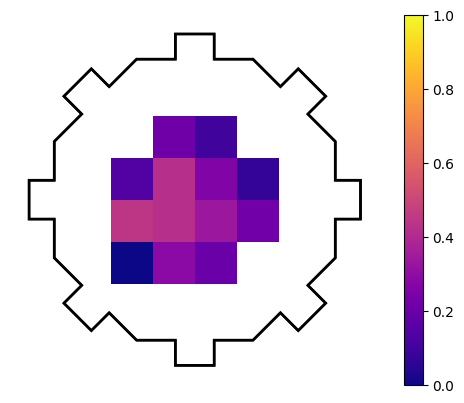

In [591]:
ax = plot_octagon.plot_octagon()
ax = plot_heatmap_from_count_array(ax, ratio_array_aggregate_data_size_cutoff, vmin=1)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

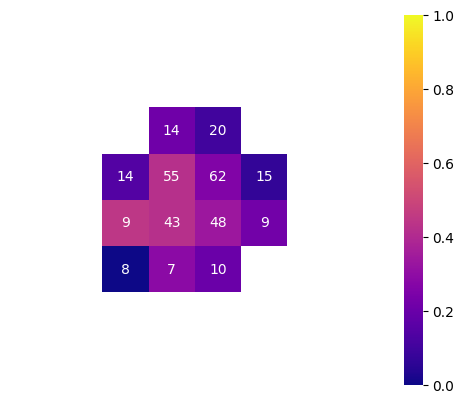

<Figure size 800x600 with 0 Axes>

[Text(0, 0.0, ''),
 Text(0, 0.2, ''),
 Text(0, 0.4, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 1.0, '')]

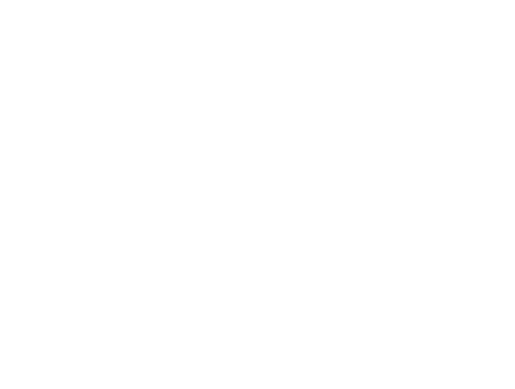

In [592]:
ax = plot_octagon.plot_octagon()
ax = plot_heatmap_from_count_array_sns(ax, ratio_array_aggregate_data_size_cutoff, summed_denominator, vmin=0, vmax=1)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])


#### TODO:
- check logic to make sure we're selecting trials and flipping/rotating correctly (This can be done by using tests/flipped_rotated_trajectory_testing.ipynb on the flattened list of trials that are going into this current analysis)
- repeat for solo
- repeat for P(H|L first vis)

#### For solo